Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

Example notebook showing a visual validation workflow for Hurricane Beryl.

In [1]:
import os
import fiona
import fiona.transform
import rasterio
import rasterio.mask
import numpy as np
import pickle
import matplotlib.pyplot as plt
import shapely.geometry
import yaml


from pigeon import annotate
import cv2
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    PrecisionRecallDisplay,
)

In [2]:
config_file = "../configs/beryl_07_05_2024_1.yml"
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

experiment_dir = config["experiment_dir"]

if "rgb_fn" in config["imagery"] and config["imagery"]["rgb_fn"] is not None:
    imagery_fn = config["imagery"]["rgb_fn"]
else:
    # Set manually
    imagery_fn = "../data/hurricane_beryl_2024/raw/merged_rgb.tif"

footprint_results_fn = "../experiments/beryl_07_05_2024_1/results-20240705_130212_ssc12_u0001-msft_footprints_merged.gpkg"
footprint_base_fn = os.path.basename(footprint_results_fn).replace(".gpkg", "")
output_fn = os.path.join("..", experiment_dir, f"{footprint_base_fn}_annotations.pkl")

In [3]:
shapes = []
y_pred = []
y_pred_pct = []
with fiona.open(footprint_results_fn) as f:
    predictions_crs = f.crs
    for i, row in enumerate(tqdm(f)):
        if row["properties"]["unknown_pct"] < 0.1:
            shapes.append(shapely.geometry.shape(row["geometry"]))
            y_pred.append(row["properties"]["damage_pct_0m"] > 0)
            y_pred_pct.append(row["properties"]["damage_pct_0m"])

100%|██████████| 3647/3647 [00:00<00:00, 9426.91it/s]


In [4]:
NUM_SAMPLES = len(shapes)

print(f"Total of {NUM_SAMPLES} rows")

idxs = np.arange(len(shapes))
np.random.shuffle(idxs)

new_idxs = []
images = []
with rasterio.open(imagery_fn) as f:
    assert f.crs == predictions_crs
    for i in tqdm(range(NUM_SAMPLES)):
        idx = idxs[i]
        shape = shapes[idx]

        if shape.area <= 100:
            continue

        envelope_shape = shape.buffer(50).envelope
        envelope_shape_minus_shape = envelope_shape - shape

        try:
            image, _ = rasterio.mask.mask(f, [envelope_shape], crop=True)
            image = np.rollaxis(image, 0, 3)

            mask_image, _ = rasterio.mask.mask(
                f, [envelope_shape_minus_shape], crop=True
            )
            mask_image = mask_image[:, 1:-1, 1:-1]
            mask = ((mask_image == 0).sum(axis=0) == f.count).astype(np.uint8)

            cont = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            image_outlines = image.copy()
            thickness = 1
            cv2.drawContours(
                image_outlines, cont[0], -1, (0, 255, 0), thickness=thickness
            )

            images.append(image_outlines)
            new_idxs.append(idx)
        except ValueError as e:
            pass

Total of 2816 rows


100%|██████████| 2816/2816 [00:06<00:00, 440.52it/s]


In [5]:
len(new_idxs)

1395

In [20]:
def show_image(i):
    img = images[i]
    idx = new_idxs[i]
    fig, axs = plt.subplots(1, 1, figsize=(10, 10), facecolor="white")
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    plt.close()


annotations = annotate(
    range(len(images)),
    options=["not damaged", "damaged", "unsure"],
    display_fn=lambda i: show_image(i),
)

HTML(value='0 examples annotated, 1396 examples left')

Output()

In [13]:
y_pred_new = []
y_pred_pct_new = []

y_true = []

for i, idx in enumerate(new_idxs):
    if i >= len(annotations):
        break
    t_y_true = annotations[i][1]
    if t_y_true == "unsure":
        continue

    y_true.append(int(t_y_true == "damaged"))
    y_pred_new.append(y_pred[idx])
    y_pred_pct_new.append(y_pred_pct[idx])

y_pred_new = np.array(y_pred_new)
y_pred_pct_new = np.array(y_pred_pct_new)

y_true = np.array(y_true)

In [19]:
len(y_pred_new)

140

In [14]:
accuracy_score(y_true, y_pred_new)

0.8785714285714286

In [15]:
recall_score(y_true, y_pred_new), precision_score(y_true, y_pred_new)

(0.9375, 0.8620689655172413)

In [16]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_pct_new)

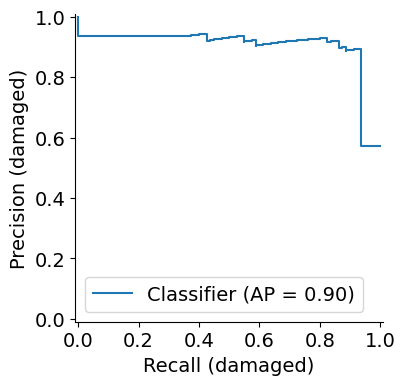

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
disp = PrecisionRecallDisplay.from_predictions(y_true, y_pred_pct_new, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower left", fontsize=14)
plt.xlabel("Recall (damaged)", fontsize=14)
plt.ylabel("Precision (damaged)", fontsize=14)

plt.show()
plt.close()

In [18]:
with open(output_fn, "wb") as f:
    pickle.dump(list(zip(new_idxs[: len(annotations)], annotations)), f)